In [9]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from rasterio.features import rasterize
import numpy as np
import matplotlib.pyplot as plt
import csv
import geopandas as gpd


In [4]:
# Define file paths
naip_path = 'data/Clipped_rasters/NAIP_2019_clipped.tif'
chm_path = 'data/Clipped_rasters/CHM_clipped.tif'
output_path = 'data/Clipped_rasters/CHM_clipped_to_NAIP2019.tif'

# Open NAIP 2019 to get its extent and transform
with rasterio.open(naip_path) as naip:
    naip_bounds = naip.bounds
    naip_crs = naip.crs
    naip_transform = naip.transform
    naip_shape = (naip.height, naip.width)

# Open CHM and read the window that overlaps with the NAIP
with rasterio.open(chm_path) as chm:
    # Ensure both are in the same CRS
    if chm.crs != naip_crs:
        raise ValueError("CHM and NAIP have different CRSs. Reproject first.")

    # Create a window from NAIP bounds
    window = from_bounds(*naip_bounds, transform=chm.transform)
    window = window.round_offsets(op='floor').round_lengths(op='ceil')

    # Read CHM data from that window
    chm_data = chm.read(1, window=window)
    chm_transform = chm.window_transform(window)

    # Define profile for the output raster
    out_profile = chm.profile.copy()
    out_profile.update({
        "height": chm_data.shape[0],
        "width": chm_data.shape[1],
        "transform": chm_transform
    })

# Save the clipped CHM
with rasterio.open(output_path, 'w', **out_profile) as dest:
    dest.write(chm_data, 1)

print("CHM successfully clipped to NAIP 2019 extent.")

CHM successfully clipped to NAIP 2019 extent.


In [5]:
# Update path: we're now using the clipped CHM as the reference
clipped_chm_path = 'data/Clipped_rasters/CHM_clipped_to_NAIP2019.tif'
resampled_naip_path = 'data/Clipped_rasters/NAIP_2019_resampled_to_CHM.tif'

# Open CHM to get target shape and transform
with rasterio.open(clipped_chm_path) as chm:
    target_transform = chm.transform
    target_shape = (chm.height, chm.width)
    target_crs = chm.crs

# Open and resample NAIP to match CHM
with rasterio.open(naip_path) as naip:
    if naip.crs != target_crs:
        raise ValueError("NAIP and CHM have different CRSs. Reproject first.")

    resampled_naip = naip.read(
        out_shape=(naip.count, target_shape[0], target_shape[1]),
        resampling=Resampling.bilinear
    )

    out_meta = naip.meta.copy()
    out_meta.update({
        "height": target_shape[0],
        "width": target_shape[1],
        "transform": target_transform
    })

# Save the resampled NAIP
with rasterio.open(resampled_naip_path, 'w', **out_meta) as dst:
    dst.write(resampled_naip)

print("NAIP successfully resampled to match CHM extent and resolution.")

NAIP successfully resampled to match CHM extent and resolution.


In [6]:
# File paths
chm_path = 'data/Clipped_rasters/CHM_clipped_to_NAIP2019.tif'
naip_path = 'data/Clipped_rasters/NAIP_2019_resampled_to_CHM.tif'

# Read CHM (single band)
with rasterio.open(chm_path) as chm_src:
    chm_band = chm_src.read(1)  # shape: (H, W)

# Read NAIP bands 1–4 (RGB + NIR)
with rasterio.open(naip_path) as naip_src:
    naip_bands = naip_src.read(indexes=[1, 2, 3, 4])  # shape: (4, H, W)

# Stack NAIP (4 bands) + CHM (1 band)
stacked = np.vstack((naip_bands, chm_band[np.newaxis, :, :]))  # shape: (5, H, W)

print(f"Raster stack created with shape: {stacked.shape} (bands, rows, cols)")

Raster stack created with shape: (5, 3074, 4685) (bands, rows, cols)


In [7]:
# Define output path
output_stack_path = 'data/Clipped_rasters/stacked_NAIP2019_CHM.tif'

# Use metadata from NAIP as base, update for 5 bands
with rasterio.open(naip_path) as src:
    out_meta = src.meta.copy()
    out_meta.update({
        "count": stacked.shape[0],  # 5 bands
        "dtype": stacked.dtype,
        "height": stacked.shape[1],
        "width": stacked.shape[2]
    })

# Write the stacked raster
with rasterio.open(output_stack_path, 'w', **out_meta) as dst:
    dst.write(stacked)

print(f"Stacked raster saved to: {output_stack_path}")

CPLE_AppDefinedError: Deleting data/Clipped_rasters/stacked_NAIP2019_CHM.tif failed: Permission denied

In [29]:
# File paths
shapefile = 'data/classification_polys/classificatio_polys.shp'
stacked_raster_path = 'data/Clipped_rasters/stacked_NAIP2019_CHM.tif'
label_raster_path = 'data/classification_polys/training_labels.tif'

# Load the training polygons
gdf = gpd.read_file(shapefile)

# Open the stacked raster to get shape, transform, CRS
with rasterio.open(stacked_raster_path) as ref:
    transform = ref.transform
    out_shape = (ref.height, ref.width)
    raster_crs = ref.crs
    meta = ref.meta.copy()

In [ ]:
# Reproject shapefile if necessary
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

In [58]:
gdf.tail()

,Classcode,Classname,Classvalue,RED,GREEN,BLUE,Count,geometry
188,None,Vegetation,4,255,255,115,1613,"POLYGON Z ((515561.446 140087.67 0, 515525.835..."
189,None,Bare_Ground,1,168,112,0,1056,"POLYGON Z ((515506.496 139907.044 0, 515473.16..."
190,None,Bare_Ground,1,168,112,0,1967,"POLYGON Z ((515569.188 139829.243 0, 515535.11..."
191,None,Bare_Ground,1,168,112,0,1828,"POLYGON Z ((515529.284 139825.612 0, 515489.14..."
192,None,Road,2,46,45,27,137,"POLYGON Z ((514134.025 138912.914 0, 514125.11..."


In [50]:
# Merge Gravel → Bare_Ground, and Crop/non_crop_vegetation → Vegetation
gdf['Classname'] = gdf['Classname'].replace({
    'Gravel': 'Bare_Ground',
    'Crop': 'Vegetation',
    'non_crop_vegitation': 'Vegetation'
})

# Remap merged and original classnames to new class values
gdf['Classvalue'] = gdf['Classname'].replace({
    'Water': 0,
    'Bare_Ground': 1,   # merged Gravel & Bare_Ground
    'Road': 2,
    'Building': 3,
    'Vegetation': 4,    # merged Crop & non_crop_vegetation
    'Deciduous': 5,
    'Coniferous': 6
})

C:\Users\tjwil\AppData\Local\Temp\ipykernel_22116\1449955948.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf['Classvalue'] = gdf['Classname'].replace({


In [60]:
# Create shapes for rasterization
shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf['Classvalue'])]

In [61]:
# Drop duplicates and build mapping
class_mapping_df = gdf[['Classvalue', 'Classname']].drop_duplicates()
class_mapping = dict(zip(class_mapping_df['Classvalue'], class_mapping_df['Classname']))

legend_path = 'data/classification_polys/predicted_labels_rf_legend.csv'

with open(legend_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Value', 'Classname'])
    for val, name in class_mapping.items():
        writer.writerow([val, name])

print(f"Class legend saved to: {legend_path}")

Class legend saved to: data/classification_polys/predicted_labels_rf_legend.csv


In [62]:
# Rasterize
label_array = rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=transform,
    fill=255,  # use 255 to indicate 'no class' or background
    dtype='uint8'
)

# Save label raster
meta.update({
    "count": 1,
    "dtype": 'uint8'
})

with rasterio.open(label_raster_path, 'w', **meta) as out:
    out.write(label_array, 1)

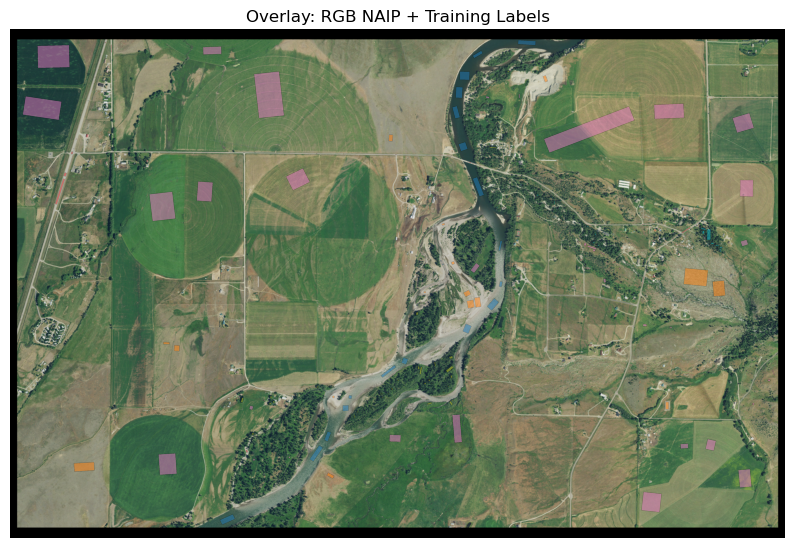

In [63]:
# Open stacked raster and read RGB bands (bands 1–3)
with rasterio.open(stacked_raster_path) as src:
    rgb = src.read([1, 2, 3])
    rgb = np.moveaxis(rgb, 0, -1)  # (H, W, 3)

    # Create mask where all bands are 0
    zero_mask = np.all(rgb == 0, axis=-1)

# Normalize for display (optional, if values are 0–255 skip this)
if rgb.max() > 255:
    rgb = (rgb / rgb.max()) * 255
rgb = rgb.astype(np.uint8)

# Apply mask: set 0-valued pixels to NaN for plotting (matplotlib can’t show NaNs, so use alpha mask)
rgb_masked = np.ma.array(rgb, mask=np.repeat(zero_mask[:, :, np.newaxis], 3, axis=2))

# Open label raster
with rasterio.open(label_raster_path) as src:
    labels = src.read(1)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(rgb_masked)
plt.imshow(np.ma.masked_where(labels == 255, labels), cmap='tab10', alpha=0.5)
plt.title("Overlay: RGB NAIP + Training Labels")
plt.axis('off')
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load stacked raster
with rasterio.open(stacked_raster_path) as src:
    stacked = src.read()         # shape: (bands, rows, cols)
    profile = src.profile
    height, width = src.height, src.width

# Load training labels
with rasterio.open(label_raster_path) as src:
    labels = src.read(1)         # shape: (rows, cols)

# Reshape features and labels
X = stacked.reshape(stacked.shape[0], -1).T  # (n_pixels, n_bands)
y = labels.flatten()                         # (n_pixels,)

# Mask out background label (255) and zero-valued pixels
band_mask = np.all(X == 0, axis=1)           # True where all bands are 0
label_mask = y != 255                        # True where label is valid

# Combine masks
valid_mask = ~band_mask & label_mask

# Apply masks
X_train = X[valid_mask]
y_train = y[valid_mask]

print(f"Training samples: {X_train.shape[0]}")

# Train/test split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_tr, y_tr)

# Evaluate
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

# Predict only on valid (non-zero) pixels
band_mask = np.all(X == 0, axis=1)  # recompute for safety
valid_pixels = ~band_mask

# Predict on valid pixels only
y_valid_pred = clf.predict(X[valid_pixels])

# Fill a full-size prediction array with 255 (nodata)
y_full_pred = np.full_like(y, fill_value=255)
y_full_pred[valid_pixels] = y_valid_pred

# Reshape to image
predicted_labels = y_full_pred.reshape(height, width)

# Update metadata for single-band classification output
profile.update({
    'count': 1,
    'dtype': 'uint8'
})

# Save the prediction as a GeoTIFF
output_pred_path = 'data/output/predicted_labels_rf_v8.tif'

with rasterio.open(output_pred_path, 'w', **profile) as dst:
    dst.write(predicted_labels.astype('uint8'), 1)

Training samples: 365101
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6879
           1       0.98      0.98      0.98      7368
           2       0.94      0.89      0.91       747
           3       0.98      0.99      0.98       121
           4       1.00      1.00      1.00     56246
           5       0.84      0.86      0.85       987
           6       0.81      0.75      0.78       673

    accuracy                           0.99     73021
   macro avg       0.93      0.93      0.93     73021
weighted avg       0.99      0.99      0.99     73021



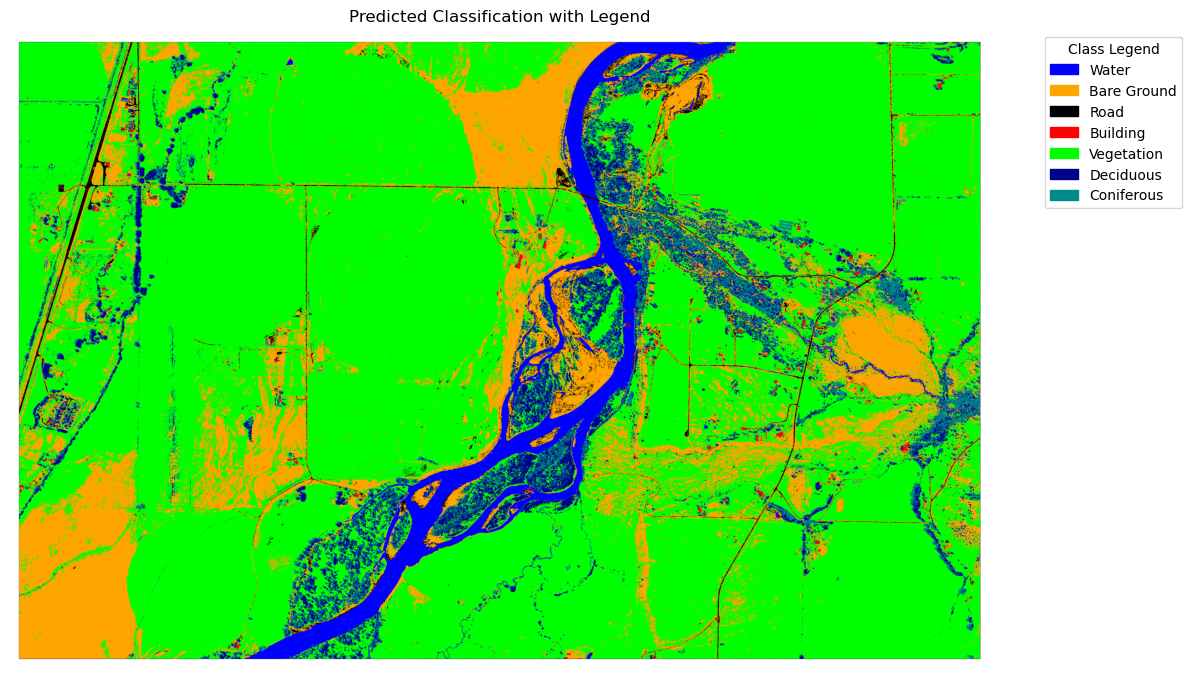

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# --- Mask 255 (nodata) ---
masked = np.ma.masked_where(predicted_labels == 255, predicted_labels)

# --- Define color and label for each class ---
class_info = {
    0: ("Water", "#0000FF"),
    1: ("Bare Ground", "#FFA500"),      # includes original Gravel
    2: ("Road", "#000000"),
    3: ("Building", "#FF0000"),
    4: ("Vegetation", "#00FF00"),       # merged Crop + Non-crop Vegetation
    5: ("Deciduous", "#00008B"),
    6: ("Coniferous", "#008B8B"),
}

# --- Create colormap and norm ---
labels_sorted = sorted(class_info.keys())
colors = [class_info[i][1] for i in labels_sorted]
cmap = mcolors.ListedColormap(colors)
bounds = list(range(len(labels_sorted) + 1))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# --- Plot ---
plt.figure(figsize=(12, 10))
plt.imshow(masked, cmap=cmap, norm=norm)
plt.title("Predicted Classification with Legend")
plt.axis('off')

# --- Add legend patches ---
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for (label, color) in [class_info[i] for i in labels_sorted]
]
plt.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title="Class Legend"
)

plt.tight_layout()
plt.show()
